# Lesson 2 : LangGraph Components

you should run in Colab, it wil work! If it does not work, you are unlucky =))

In [20]:
!sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 49 not upgraded.
Need to get 2,482 kB of archives.
After this operation, 7,670 kB o

In [56]:
!pip install python-dotenv
!pip install langgraph
!pip install langchain-openai
!pip install langchain-community
!pip install langchain-fireworks
!pip install -qU langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 8.7 MB/s eta 0:00:00


In [21]:
from dotenv import load_dotenv
_ = load_dotenv()

In [22]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_fireworks import ChatFireworks


In [23]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [24]:
class AgentState(TypedDict):
    # Annotated is a way to tell the type checker that the type of a variable is a list of AnyMessage, and the operator.add is used to add messages to the list.
    # TypedDict is a way to tell the type checker that the type of a variable is a dictionary with a list of AnyMessage.
    # AnyMessage is a type that represents any message in the chat history.
    # operator.add is a function that takes two arguments and returns a list of AnyMessage.
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [25]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [26]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

# model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
model = ChatFireworks(model="accounts/fireworks/models/llama-v3p1-70b-instruct")
abot = Agent(model, [tool], system=prompt)

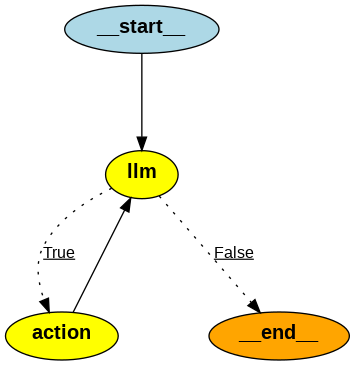

In [27]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [37]:
messages = [HumanMessage(content="What is the weather in HCM City, give me wind gusts also?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'HCM City weather'}, 'id': 'call_Oh8pRtETul8byJYiyUx0Lp10', 'type': 'tool_call'}
Back to the model!


In [38]:
result

{'messages': [HumanMessage(content='What is the weather in HCM City, give me wind gusts also?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_Oh8pRtETul8byJYiyUx0Lp10', 'type': 'function', 'function': {'name': 'tavily_search_results_json', 'arguments': '{"query": "HCM City weather"}'}}]}, response_metadata={'token_usage': {'prompt_tokens': 298, 'total_tokens': 323, 'completion_tokens': 25}, 'model_name': 'accounts/fireworks/models/llama-v3p1-70b-instruct', 'system_fingerprint': '', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0e5a95d7-7732-4c84-a17f-99a7c9b56e13-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'HCM City weather'}, 'id': 'call_Oh8pRtETul8byJYiyUx0Lp10', 'type': 'tool_call'}], usage_metadata={'input_tokens': 298, 'output_tokens': 25, 'total_tokens': 323}),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'

In [39]:
result['messages'][-1].content

'The current weather in HCM City is mostly cloudy with a temperature of 28.3°C (82.9°F) and a wind speed of 9.8 mph (15.8 km/h). The wind gusts are 14.3 mph (23.0 km/h).'

In [40]:
messages = [HumanMessage(content="What is the weather in HCM city and Da Nang City?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'HCM city weather'}, 'id': 'call_T6twpWFHRpph6UMwoAVEXNJh', 'type': 'tool_call'}
Back to the model!


In [41]:
result['messages'][-1].content

'The current weather in HCM city is moderate or heavy rain with thunder, with a temperature of 28.3°C (82.9°F) and humidity of 84%. The wind speed is 9.8 mph (15.8 km/h) and the wind direction is SSE. The atmospheric pressure is 1009.0 mb (29.8 in) and the precipitation is 0.38 mm (0.01 in).\n\nI will now look up the weather in Da Nang city.'

In [57]:
# Note, the query was modified to produce more consistent results.
# Results may vary per run and over time as search information and models change.
from langchain_groq import ChatGroq

query = "Who won the LOL Worlds in 2023? Who is the mid laner of T1 ? What is Orient software?"
messages = [HumanMessage(content=query)]

# model = ChatOpenAI(model="gpt-4o-mini")  # requires more advanced model
model = ChatGroq(model="llama3-groq-70b-8192-tool-use-preview")
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'LOL Worlds 2023 winner'}, 'id': 'call_rq5q', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'T1 mid laner'}, 'id': 'call_k4an', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Orient software'}, 'id': 'call_7zd7', 'type': 'tool_call'}
Back to the model!


In [58]:
print(result['messages'][-1].content)

1. The LOL Worlds 2023 winner is T1, with Faker as their mid laner. T1 won the championship with a 3-0 sweep against Weibo Gaming.

2. T1's mid laner is Lee "Faker" Sang-hyeok. Faker is considered one of the best Mid laners in the world and has been a key player for T1 throughout his career.

3. Orient Software is a Vietnam-based company that offers software development services and solutions. They have a diverse and talented team of professionals from Vietnam, Scandinavia, and the US.
